# FCN VOC 2012 and SBD Semi Supervised Learning

In [1]:
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision
from torchvision import models
import torch.utils.data as tud
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm
from PIL import Image
from collections import Counter
from sklearn.metrics import jaccard_score
import pickle
import my_datasets as mdset
import eval_train as ev
from utils import * 




## Dataset : Pascal VOC 2012

In [2]:
dataroot_voc = '/data/voc2012'
dataroot_sbd = '/data/sbd'
model_name = 'fcn_voc_sbd30_semisup_g05_CE'
SAVE_DIR = '/data/model'
save = os.path.join(SAVE_DIR,model_name)
batch_size = 2
gamma = 0.5
save_all_ep = True
#criterion_unsupervised = nn.L1Loss(reduction='mean')
#criterion_unsupervised = nn.KLDivLoss(reduction = 'batchmean', log_target = False)
criterion_unsupervised = nn.CrossEntropyLoss(ignore_index=21)
criterion_supervised = nn.CrossEntropyLoss(ignore_index=21) # On ignore la classe border.
Loss = 'CE' # Loss = 'KL' or 'CE' or None for L1,MSE…
rotate = False
split = True
fully_supervised = True # Use the same dataloader for equivariance loss and supervised loss
pretrain_model = False # Pretrain the model in a fully supervised way before appli equiv loss
n_epochs_supervised = 20 # Train in fully supervised for n_epoch_supervised
eval_before_semisup = True # Eval the loaded model before training with equiv_loss 

In [3]:
train_dataset_VOC = mdset.VOCSegmentation(dataroot_voc,year='2012', image_set='train', download=True,rotate=rotate)
val_dataset_VOC = mdset.VOCSegmentation(dataroot_voc,year='2012', image_set='val', download=True)
train_dataset_SBD = mdset.SBDataset(dataroot_sbd, image_set='train_noval',mode='segmentation',rotate=rotate)

Using downloaded and verified file: /data/voc2012/VOCtrainval_11-May-2012.tar
Using downloaded and verified file: /data/voc2012/VOCtrainval_11-May-2012.tar


### Concatene Dataset

In [4]:
train_dataset_unsup = tud.ConcatDataset([train_dataset_VOC,train_dataset_SBD])

### Split dataset

In [5]:
if split:
    train_dataset_sup = split_dataset(train_dataset_unsup,0.3)

In [6]:
if fully_supervised : 
    train_dataset_unsup = train_dataset_sup

dataloader_train_VOC = torch.utils.data.DataLoader(train_dataset_VOC, batch_size=batch_size,\
                                                       shuffle=True,drop_last=True)
dataloader_train_sup = torch.utils.data.DataLoader(train_dataset_sup, batch_size=batch_size,\
                                                       shuffle=True,drop_last=True)
dataloader_train_equiv = torch.utils.data.DataLoader(train_dataset_unsup,batch_size=batch_size,\
                                                     shuffle=True,drop_last=True)

dataloader_val = torch.utils.data.DataLoader(val_dataset_VOC, batch_size=batch_size)
# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device :",device)



device : cuda:0


In [7]:
print("Taille dataset train supervised :",len(train_dataset_sup))
print("Taille dataset train unsupervised :",len(train_dataset_unsup))
print("Taille dataset val VOC :",len(val_dataset_VOC))

Taille dataset train supervised : 2126
Taille dataset train unsupervised : 2126
Taille dataset val VOC : 1449



## FCN Pytorch

In [8]:
def load_model(file=None,fcn=False,pretrained=False):
    if file is None:
        if fcn is False:
            model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=pretrained)
        else:
            model = torchvision.models.segmentation.fcn_resnet101(pretrained=pretrained)
    else:
        model = torch.load(os.path.join(SAVE_DIR,file))
    return model

In [9]:
model = load_model(file='fcn_voc_sbd30_semisup_g05_CE_pretrain_sup_ep24.pt')

In [10]:
model.to(device)

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

## Training


In [11]:
learning_rate = 10e-4
moment = 0.9
wd = 2e-4
n_epochs = 26
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,momentum=moment, weight_decay=wd)
angle_max = 30


In [12]:
iou_train = []
iou_test = []
combine_loss_train = []
combine_loss_test = []
loss_train_unsup = []
loss_train_sup = []
loss_test = []
loss_test_unsup = []
pix_accuracy_train = []
pix_accuracy_test = []
accuracy_test = []
accuracy_train = []
#
all_combine_loss_train = []
all_loss_train_sup = []
all_loss_train_unsup = []
all_iou_train= []
all_pix_accuracy =  []

### Pretrain fully supervised 

In [13]:
## pretrain the model in fully supervised
if pretrain_model:
    torch.autograd.set_detect_anomaly(True)
    for ep in range(n_epochs_supervised):
        print("EPOCH",ep)
        model.train()
        for i,(x,mask) in enumerate(dataloader_train_sup):
            x = x.to(device)
            mask = mask.to(device)  
            pred = model(x)
            pred = pred["out"]
            loss = criterion_supervised(pred,mask)
            all_loss_train_sup.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            all_iou_train.append(inter_over_union(pred.argmax(dim=1).detach().cpu(),mask.detach().cpu()))
            optimizer.step()        

        #lr_scheduler.step()
        m_iou = np.array(all_iou_train).mean()
        m_loss = np.array(all_loss_train_sup).mean()
        loss_train_sup.append(m_loss)
        iou_train.append(m_iou)
        all_loss_train_sup = []
        all_iou_train = []
        print("EP:",ep," loss train:",m_loss," iou train:",m_iou)

        #Eval model

        model.eval()
        state = ev.eval_model(model,dataloader_val,device=device,num_classes=21)
        iou = state.metrics['mean IoU']
        acc = state.metrics['accuracy']
        loss = state.metrics['CE Loss'] 
        loss_test.append(loss)
        iou_test.append(iou)
        accuracy_test.append(acc)
        print('EP:',ep,'iou:',state.metrics['mean IoU'],\
              'Accuracy:',state.metrics['accuracy'],'Loss CE',state.metrics['CE Loss'])

        torch.save(model,save)
        ## Save model
        if save_all_ep:
            save_model = model_name+'_pretrain_sup'+'_ep'+str(ep)+'.pt'
            save = os.path.join(SAVE_DIR,save_model)
            torch.save(model,save)
        else:
            save_model = model_name+'_pretrain_sup'+'.pt'
            save = os.path.join(SAVE_DIR,save_model)
            torch.save(model,save)
    

In [14]:
if eval_before_semisup:
    model.eval()
    print("EVAL ON TRAIN VOC 2012:")
    m_pix_acc, m_loss_equiv = eval_accuracy_equiv(model,dataloader_train_VOC,criterion=criterion_unsupervised,\
                            nclass=21,device=device,Loss=Loss,plot=False,angle_max=30,random_angle=False) 
    d_iou = ev.eval_model_all_angle(model,train=True,batch_size=batch_size,device=device,num_classes=21)
    print("EVAL ON VAL VOC 2012:")
    m_pix_acc, m_loss_equiv = eval_accuracy_equiv(model,dataloader_val,criterion=criterion_unsupervised,\
                            nclass=21,device=device,Loss=Loss,plot=False,angle_max=30,random_angle=False) 
    d_iou = ev.eval_model_all_angle(model,train=False,batch_size=batch_size,device=device,num_classes=21)


EVAL ON TRAIN VOC 2012:


/workspace/utils.py:143: RuntimeWarning: invalid value encountered in true_divide
  acc_cls = np.diag(hist) / hist.sum(axis=1)
/workspace/utils.py:145: RuntimeWarning: invalid value encountered in true_divide
  iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))


Mean Pixel Accuracy between masks : 0.8897690777392369 Loss Validation : 0.4146496
Using downloaded and verified file: /data/voc2012/VOCtrainval_11-May-2012.tar
Using downloaded and verified file: /data/voc2012/VOCtrainval_11-May-2012.tar
Using downloaded and verified file: /data/voc2012/VOCtrainval_11-May-2012.tar
Using downloaded and verified file: /data/voc2012/VOCtrainval_11-May-2012.tar
Using downloaded and verified file: /data/voc2012/VOCtrainval_11-May-2012.tar
Scores for datasets rotate by 0 degrees:
   mIoU 0.5240008692751881 Accuracy 0.8850775894647072 CE Loss 0.43837245313140255
Scores for datasets rotate by 10 degrees:
   mIoU 0.457758060101738 Accuracy 0.8722306030127397 CE Loss 0.49746077703668284
Scores for datasets rotate by 20 degrees:
   mIoU 0.37492098496276033 Accuracy 0.8544925651534258 CE Loss 0.5815517240091955
Scores for datasets rotate by 30 degrees:
   mIoU 0.33881706308489246 Accuracy 0.8476700981343163 CE Loss 0.6167368859490329
Scores for datasets rotate by

### Semi sup training

In [15]:
learning_rate = 2*10e-4

In [16]:
torch.autograd.set_detect_anomaly(True)
for ep in range(n_epochs):
    #dataloader_train_sup = torch.utils.data.DataLoader(train_dataset_sup, batch_size=batch_size,\
                                                      # shuffle=True,drop_last=True)
    #dataloader_train_equiv = torch.utils.data.DataLoader(train_dataset_unsup,batch_size=batch_size,\
                                                     #shuffle=True,drop_last=True)
    print("EPOCH",ep)
    model.train()

    for batch_sup,batch_unsup in zip(dataloader_train_sup,dataloader_train_equiv):
        optimizer.zero_grad()
        if random.random() > 0.5: # I use this to rotate the image on the left and on the right during training.
            angle = np.random.randint(0,angle_max)
        else:
            angle = np.random.randint(360-angle_max,360)
        x_unsup,_ = batch_unsup
        loss_equiv,acc = compute_transformations_batch(x_unsup,model,angle,reshape=False,\
                                                     criterion=criterion_unsupervised,Loss = Loss,\
                                                       device=device)
        x,mask = batch_sup
        x = x.to(device)
        mask = mask.to(device)
        pred = model(x)["out"]
        loss_equiv = loss_equiv.to(device) # otherwise bug in combining the loss 
        loss_sup = criterion_supervised(pred,mask)
        loss = gamma*loss_sup + (1-gamma)*loss_equiv # combine loss              
        loss.backward()
        optimizer.step()
        
        # append for plot
        all_pix_accuracy.append(acc) # accuracy between the original mask and the transform mask put back in place
        all_loss_train_unsup.append(loss_equiv.item())
        all_loss_train_sup.append(loss_sup.item())
        all_combine_loss_train.append(loss.item())
            
    #lr_scheduler.step()
    #
    # Eval IoU Train 
    state = ev.eval_model(model,dataloader_val,device=device,num_classes=21)
    iou = state.metrics['mean IoU']
    iou_train.append(iou)
    m_loss_combine = np.array(all_combine_loss_train).mean()
    m_acc = np.array(all_pix_accuracy).mean()
    combine_loss_train.append(m_loss_combine)
    pix_accuracy_train.append(m_acc)
    loss_train_sup.append(np.array(all_loss_train_sup).mean())
    loss_train_unsup.append(np.array(all_loss_train_unsup).mean())

    all_pix_accuracy = []
    all_loss_train_unsup = []
    all_loss_train_sup = []
    all_combine_loss_train = []
    print("loss sup :",loss_sup.item(),"loss unsup :",loss_equiv.item(),"loss :",loss.item(),"iou train :",iou) 
    print("EP:",ep," combine loss train:",m_loss_combine," pixel accuracy between masks ",m_acc)

    ## Evaluate the  model
    model.eval()
    state = ev.eval_model(model,dataloader_val,device=device,num_classes=21)
    iou = state.metrics['mean IoU']
    acc = state.metrics['accuracy']
    loss = state.metrics['CE Loss']
    print('EP:',ep,'iou:',state.metrics['mean IoU'],\
          'Accuracy:',state.metrics['accuracy'],'Loss CE',state.metrics['CE Loss'])
    loss_test.append(loss)
    iou_test.append(iou)
    accuracy_test.append(acc)
    if ep%3==0:
        m_pix_acc, m_loss_equiv = eval_accuracy_equiv(model,dataloader_val,criterion=criterion_unsupervised,\
                        nclass=21,device=device,Loss=Loss,plot=False,angle_max=30,random_angle=False)
        loss_test_unsup.append(m_loss_equiv)
        pix_accuracy_test.append(m_pix_acc)
        
    if ep%5==0:
        print('VOC Dataset Train')
        d_iou = ev.eval_model_all_angle(model,train=True,batch_size=batch_size,device=device,num_classes=21)
        print('VOC Dataset Val')
        d_iou = ev.eval_model_all_angle(model,train=False,batch_size=batch_size,device=device,num_classes=21)
    ## Save model
    if save_all_ep:
        save_model = model_name+'_ep'+str(ep)+'.pt'
        save = os.path.join(SAVE_DIR,save_model)
        torch.save(model,save)
    else:
        save_model = model_name+'.pt'
        save = os.path.join(SAVE_DIR,save_model)
        torch.save(model,save)

EPOCH 0
loss sup : 0.40927693247795105 loss unsup 0.045860279351472855 loss 0.2275686115026474
EP: 0  combine loss train: 0.17605282627011062  pixel accuracy between masks  0.9490094530678375
EP: 0 iou: 0.4786533360428321 Accuracy: 0.8752753837578252 Loss CE 0.44556689870545707
Mean Pixel Accuracy between masks : 0.9020203682921852 Loss Validation : 0.3383574
VOC Dataset Train
Using downloaded and verified file: /data/voc2012/VOCtrainval_11-May-2012.tar
Using downloaded and verified file: /data/voc2012/VOCtrainval_11-May-2012.tar
Using downloaded and verified file: /data/voc2012/VOCtrainval_11-May-2012.tar
Using downloaded and verified file: /data/voc2012/VOCtrainval_11-May-2012.tar
Using downloaded and verified file: /data/voc2012/VOCtrainval_11-May-2012.tar
Using downloaded and verified file: /data/voc2012/VOCtrainval_11-May-2012.tar
Using downloaded and verified file: /data/voc2012/VOCtrainval_11-May-2012.tar
Scores for datasets rotate by 0 degrees:
   mIoU 0.4786533360428321 Accura

In [17]:
model.eval()
print("EVAL ON TRAIN VOC 2012:")
m_pix_acc, m_loss_equiv = eval_accuracy_equiv(model,dataloader_train_VOC,criterion=criterion_unsupervised,\
                        nclass=21,device=device,Loss=Loss,plot=False,angle_max=30,random_angle=False) 
d_iou = ev.eval_model_all_angle(model,train=True,batch_size=batch_size,device=device,num_classes=21)
print("EVAL ON VAL VOC 2012:")
m_pix_acc, m_loss_equiv = eval_accuracy_equiv(model,dataloader_val,criterion=criterion_unsupervised,\
                        nclass=21,device=device,Loss=Loss,plot=False,angle_max=30,random_angle=False) 
d_iou = ev.eval_model_all_angle(model,train=False,batch_size=batch_size,device=device,num_classes=21)

EVAL ON TRAIN VOC 2012:
Mean Pixel Accuracy between masks : 0.9184936645582533 Loss Validation : 0.25705704
Using downloaded and verified file: /data/voc2012/VOCtrainval_11-May-2012.tar
Using downloaded and verified file: /data/voc2012/VOCtrainval_11-May-2012.tar
Using downloaded and verified file: /data/voc2012/VOCtrainval_11-May-2012.tar
Using downloaded and verified file: /data/voc2012/VOCtrainval_11-May-2012.tar
Using downloaded and verified file: /data/voc2012/VOCtrainval_11-May-2012.tar
Using downloaded and verified file: /data/voc2012/VOCtrainval_11-May-2012.tar
Using downloaded and verified file: /data/voc2012/VOCtrainval_11-May-2012.tar
Scores for datasets rotate by 0 degrees:
   mIoU 0.5262715975016434 Accuracy 0.8892668698669447 CE Loss 0.43629158897544235
Scores for datasets rotate by 10 degrees:
   mIoU 0.4687508288270747 Accuracy 0.8777675175615158 CE Loss 0.49150635361737605
Scores for datasets rotate by 20 degrees:
   mIoU 0.4183366138695479 Accuracy 0.8673543546092412 

## Plot

Text(0, 0.5, 'Mean IOU')

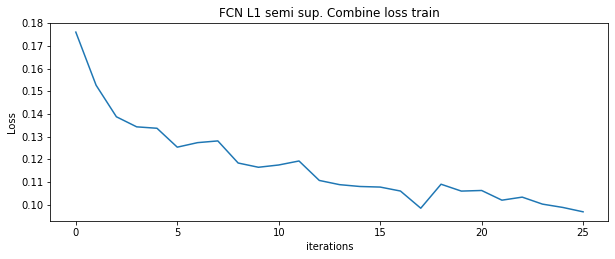

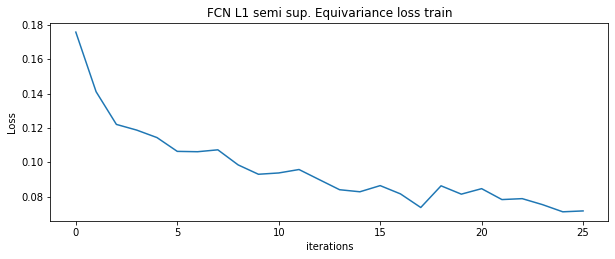

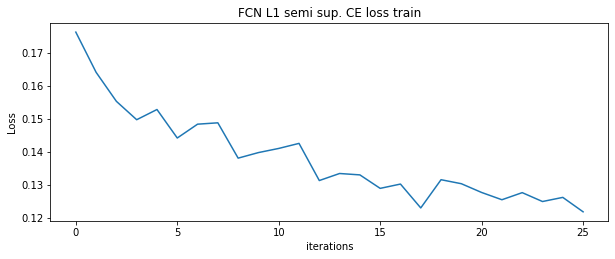

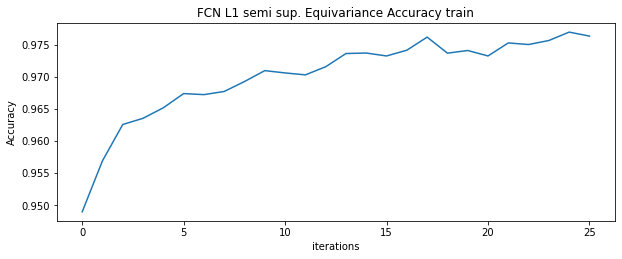

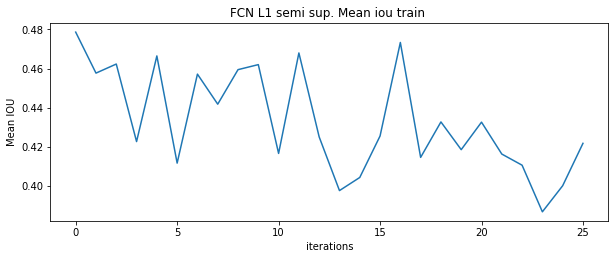

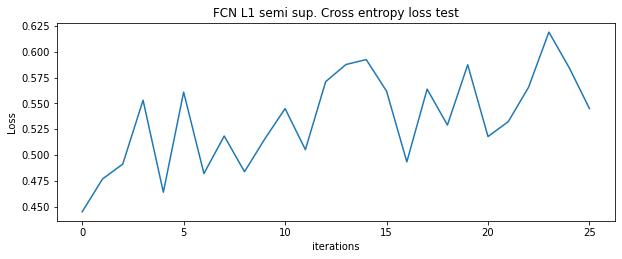

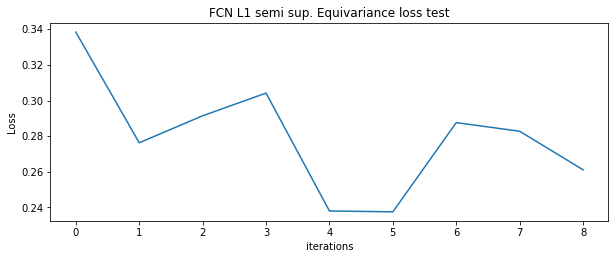

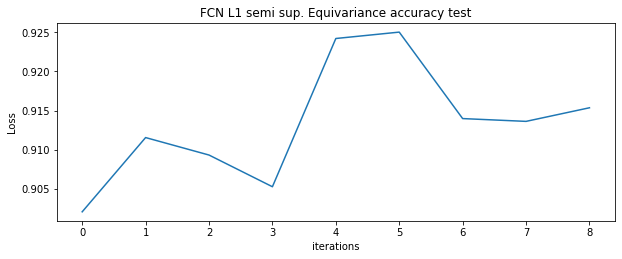

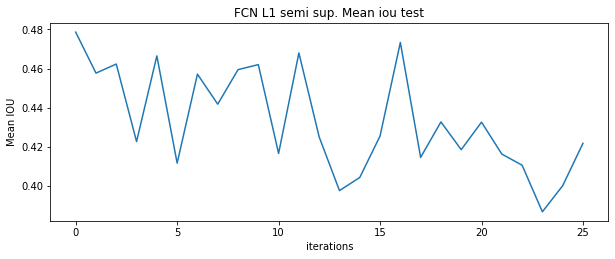

In [18]:
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCN L1 multi-task. Combine loss train")
plt.plot(combine_loss_train)
plt.xlabel("iterations")
plt.ylabel("Loss")

plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCN L1 multi-task. Equivariance loss train")
plt.plot(loss_train_unsup)
plt.xlabel("iterations")
plt.ylabel("Loss")

plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCN L1 multi-task. CE loss train")
plt.plot(loss_train_sup)
plt.xlabel("iterations")
plt.ylabel("Loss")

plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCN L1 multi-task. Equivariance Accuracy train")
plt.plot(pix_accuracy_train)
plt.xlabel("iterations")
plt.ylabel("Accuracy")

plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCN L1 multi-task. Mean iou train ")
plt.plot(iou_train)
plt.xlabel("iterations")
plt.ylabel("Mean IOU")

plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCN L1 multi-task. Cross entropy loss test")
plt.plot(loss_test)
plt.xlabel("iterations")
plt.ylabel("Loss")

plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCN L1 multi-task. Equivariance loss test")
plt.plot(loss_test_unsup)
plt.xlabel("iterations")
plt.ylabel("Loss")

plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCN L1 multi-task. Equivariance accuracy test")
plt.plot(pix_accuracy_test)
plt.xlabel("iterations")
plt.ylabel("Loss")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCN L1 multi-task. Mean iou test")
plt.plot(iou_test)
plt.xlabel("iterations")
plt.ylabel("Mean IOU")